# Anxiety vs Depression

In [1]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [2]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [3]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")

spin_fill_df = pd.read_pickle("ls_data/jama_data/all_state_shift_no_imp.df")
shift_df = pd.read_pickle("ls_data/jama_data/all_phq_shift_imp.df")

In [4]:
all_inv_df = spin_fill_df[['pid', 'study_wk', 'survey_idx', 'baseline_cluster', 'gad_total', 'spin_total']].copy()

In [5]:
all_inv_df = all_inv_df.merge(shift_df[['pid', 'study_wk', 'phq_total_sc']], on=['pid', 'study_wk'], how='left')

## Across participant correlations

- each weekly check-in for each participant is considered iid

In [6]:
target_cols = ['gad_total', 'spin_total', 'phq_total_sc']
all_inv_df['gad_total'] = all_inv_df['gad_total'].astype(float)

In [7]:
all_inv_df = all_inv_df.dropna(subset=['gad_total', 'phq_total_sc'], axis='rows')

In [8]:
across_corr = pg.pairwise_corr(all_inv_df, columns=target_cols, padjust='fdr_bh')[['X', 'Y', 'method', 'tail', 'n', 'r', 'CI95%', 'p-unc', 'p-corr', 'p-adjust']]
display(across_corr)

,X,Y,method,tail,n,r,CI95%,p-unc,p-corr,p-adjust
0,gad_total,spin_total,pearson,two-sided,1293,0.549,"[0.51, 0.59]",7.176756e-103,1.076513e-102,fdr_bh
1,gad_total,phq_total_sc,pearson,two-sided,1295,0.707,"[0.68, 0.73]",4.350996e-197,1.305299e-196,fdr_bh
2,spin_total,phq_total_sc,pearson,two-sided,1293,0.473,"[0.43, 0.51]",6.670308e-73,6.670308e-73,fdr_bh


## Within participant correlations: repeated measures correlation (rm_corr)

- ANCOVA adjustment for inter-individual variability
- Provides best linear fit per participant with parallel regression lines
- [paper reference](https://www.frontiersin.org/articles/10.3389/fpsyg.2017.00456/full)

In [9]:
# remove individuals with only one reading or 0 variance between readings
all_inv_df = all_inv_df[~all_inv_df['pid'].isin(['14196469', '29584096', '70483015', '70027963', '81720300'])]

In [10]:
pids = all_inv_df['pid'].unique()
np.random.seed(0)
sel_pids = np.random.choice(pids, 75)
sel_df = all_inv_df[all_inv_df['pid'].isin(sel_pids)]

In [11]:
rm_corrs = pd.DataFrame()
pairs = [pair for pair in zip(across_corr['X'], across_corr['Y'])]

In [12]:
with warnings.catch_warnings(record=True):
    for x, y in pairs:
        rm_corr = pg.rm_corr(data=all_inv_df, x=x, y=y, subject='pid')
        rm_corr['X'] = x
        rm_corr['Y'] = y
        rm_corrs = rm_corrs.append(rm_corr)

In [13]:
rm_corrs = rm_corrs.reset_index(drop=True)
cols = rm_corrs.columns.tolist()
rm_cols = cols[-2:] + cols[:-2]
display(rm_corrs[rm_cols])

,X,Y,r,dof,pval,CI95%,power
0,gad_total,spin_total,0.184,1024,2.876501e-09,"[0.12, 0.24]",1.000
1,gad_total,phq_total_sc,0.331,1026,1.092773e-27,"[0.28, 0.38]",1.000
2,spin_total,phq_total_sc,0.087,1024,5.407852e-03,"[0.03, 0.15]",0.795


### Repeated measure correlation plots

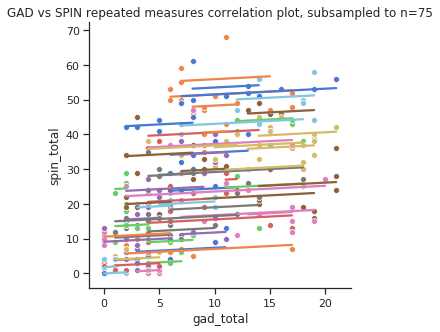

In [14]:
pg.plot_rm_corr(data=sel_df, x='gad_total', y='spin_total', subject='pid', 
                kwargs_facetgrid={
                    'height': 4.5, 
                    'aspect': 1,
                    'palette':'muted'})
plt.title("GAD vs SPIN repeated measures correlation plot, subsampled to n=75");

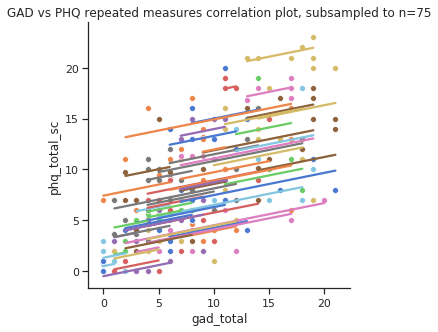

In [15]:
pg.plot_rm_corr(data=sel_df, x='gad_total', y='phq_total_sc', subject='pid', 
                kwargs_facetgrid={
                    'height': 4.5, 
                    'aspect': 1,
                    'palette':'muted'})
plt.title("GAD vs PHQ repeated measures correlation plot, subsampled to n=75");

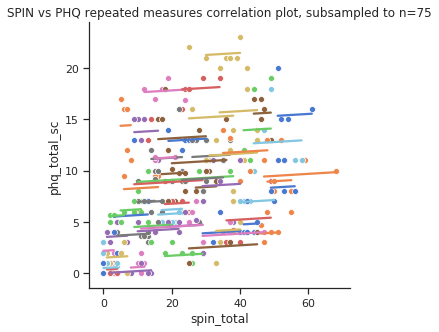

In [16]:
pg.plot_rm_corr(data=sel_df, x='spin_total', y='phq_total_sc', subject='pid', 
                kwargs_facetgrid={
                    'height': 4.5, 
                    'aspect': 1,
                    'palette':'muted'})
plt.title("SPIN vs PHQ repeated measures correlation plot, subsampled to n=75");

**Notes**

- across individual correlation considers all points, while within-individual correlations considers the slope of each within-individual regression line